In [1]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data_loader import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models import train_model, CombinedLoss
from models.autoencoders import AutoEncoder
from torch.optim import Adam
from tqdm import tqdm

# Data Loading

Config initialisation

In [2]:
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

In [3]:
data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,…,feature_49,feature_51,feature_52,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,34,1,3.889038,1.509601,0.885045,2.831856,-1.201967,11,7,76,-0.271028,0.695742,0.794157,-0.038239,0.045858,0.030772,-0.900359,-0.382682,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.586801,0.250828,0.294883,0.521403,-0.682683,-0.239552,-0.460341,1.955693,1.485422,-0.253407,…,1.380354,1.116463,1.92235,0.375684,-1.258121,-0.705236,0.748627,0.643394,0.627821,1.411739,-1.36224,0.414762,0.683652,0.896076,-1.06081,-0.636584,-0.423285,0.055839,0.424335,-0.108809,1.035421,1.629745,-0.407497,-0.345388,-0.342097,-0.281208,-0.406524,-0.258637,0.573992,-0.319932,-0.335376,-0.21128,-0.279558,-0.434355,-1.220439,0.214211,-0.257941
0,35,1,3.889038,1.636899,1.224167,2.786362,-1.050494,11,7,76,-0.310024,0.05155,0.600186,-0.054901,-0.167249,-0.014244,-0.885459,-0.254649,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.189785,0.945696,1.106982,0.392782,-0.657124,-0.220858,-0.466647,0.24926,0.994481,0.17161,…,1.066112,-1.037891,1.715097,0.067716,-0.876391,0.051228,0.806862,0.703435,0.148378,1.411131,-1.36224,0.41464,0.768911,0.571721,-1.158224,-0.932629,-0.209845,-0.144411,0.304465,-0.11591,0.342235,1.448319,-0.333611,-0.407654,-0.205946,-0.170852,-0.350776,-0.286903,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239
0,36,1,3.889038,1.751107,-0.195755,2.280836,-1.308689,11,7,76,-0.292135,-0.202836,0.615877,-0.075484,-0.318359,-0.049205,-0.930674,-0.666436,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.15204,0.121289,0.794614,0.664937,-0.615451,-0.169856,-0.365646,0.076389,1.351177,0.60942,…,1.095427,-1.714377,1.889433,-0.257992,-1.178176,-0.281169,1.45806,0.599523,-0.062305,1.499916,-1.36224,0.401396,0.701324,0.793441,-0.810332,-0.421096,-0.424012,-0.189834,0.255931,-0.067103,-0.06556,1.456399,-0.405195,-0.351057,-0.189416,-0.220496,-0.373879,-0.340003,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819
0,37,1,3.889038,1.869932,-1.48951,1.470981,-1.040105,11,7,76,-0.34881,-0.476177,0.599473,-0.064814,-0.145902,-0.037824,-0.917428,-0.682684,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.723722,0.289863,0.752283,0.108357,-0.439932,-0.221922,-0.311707,0.186232,1.29547,0.394812,…,0.979125,1.078464,0.791492,-0.55243,-1.282962,0.223554,1.172299,0.73975,-0.584127,1.038086,-1.36224,0.627579,0.601162,0.763969,-0.77326,-0.32353,-0.36246,-0.326542,0.226188,-0.114877,-0.216078,1.169394,-0.405249,-0.399258,-0.282878,-0.236362,-0.322532,-0.284416,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722
0,38,1,3.889038,1.653586,-1.510579,1.045217,-1.045805,11,7,76,-0.359463,-0.173339,0.599964,-0.082462,-0.182317,-0.046782,-0.532617,-0.188155,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.52142,0.685667,0.240129,0.750362,-0.025711,-0.1079

Ensure sorted by time_id to create batches not leaked

In [4]:
data = data.sort(by="time_id")

Define features and target

In [5]:
target = "responder_6"
features = [col for col in data.columns if "feature" in col]

X, y = data[features], data[target]

Split data

In [6]:
n = X.height
n_train = int(0.8 * n)
X_train = X.slice(0, n_train)
y_train = y.slice(0, n_train)

X_val = X.slice(n_train)
y_val = y.slice(n_train)

Data Wraper

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        y = torch.tensor(y.to_numpy(), dtype=torch.float32)
        if y.ndim == 1:
            y = y.view(-1, 1)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [9]:
train_data_loader = DataLoader(
    train_dataset, batch_size=2048, shuffle=False, num_workers=8
)
val_data_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=8)

# Reconstruction Tweaking

In [10]:
lr = 1e-2
device = torch.device("cuda")
alpha = 1.0
beta = 0.0
n_epochs = 10

In [11]:
n_feat = len(features)
n_latent = 16
encoder_hidden = [64, 32, 32]
decoder_hidden = [32, 64]
head_hidden = [8, 4]

### Drop out 

In [12]:
drop_out_values = [0, 0.15, 0.3]

In [13]:
models_drop_out = { p : AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
    dropout_p=p
) for p in drop_out_values }

  0%|          | 0/3 [00:00<?, ?it/s]

Training model with dropout 0


Epoch 01 | loss=1021.781 | R2_rec_train=-1.6855 | R2_rec_val=-0.0277 | R2_sup_train=-0.4623 | R2_sup_val=-0.4128


Epoch 02 | loss=280.206 | R2_rec_train=0.1454 | R2_rec_val=0.2215 | R2_sup_train=-0.4202 | R2_sup_val=-0.3835


Epoch 03 | loss=226.989 | R2_rec_train=0.2741 | R2_rec_val=0.2458 | R2_sup_train=-0.3817 | R2_sup_val=-0.3460


Epoch 04 | loss=207.030 | R2_rec_train=0.3279 | R2_rec_val=0.3251 | R2_sup_train=-0.3251 | R2_sup_val=-0.2960


Epoch 05 | loss=178.683 | R2_rec_train=0.3963 | R2_rec_val=0.3685 | R2_sup_train=-0.2955 | R2_sup_val=-0.2951


Epoch 06 | loss=168.074 | R2_rec_train=0.4429 | R2_rec_val=0.4091 | R2_sup_train=-0.2702 | R2_sup_val=-0.2652


Epoch 07 | loss=155.367 | R2_rec_train=0.4787 | R2_rec_val=0.4067 | R2_sup_train=-0.2598 | R2_sup_val=-0.2534


Epoch 08 | loss=159.753 | R2_rec_train=0.4687 | R2_rec_val=0.4165 | R2_sup_train=-0.2332 | R2_sup_val=-0.2376


Epoch 09 | loss=138.774 | R2_rec_train=0.5278 | R2_rec_val=0.4556 | R2_sup_train=-0.2326 | R2_sup_val=-0.2306


100%|██████████| 10/10 [01:14<00:00,  7.45s/it]

Epoch 10 | loss=139.971 | R2_rec_train=0.5250 | R2_rec_val=0.4510 | R2_sup_train=-0.2141 | R2_sup_val=-0.2203


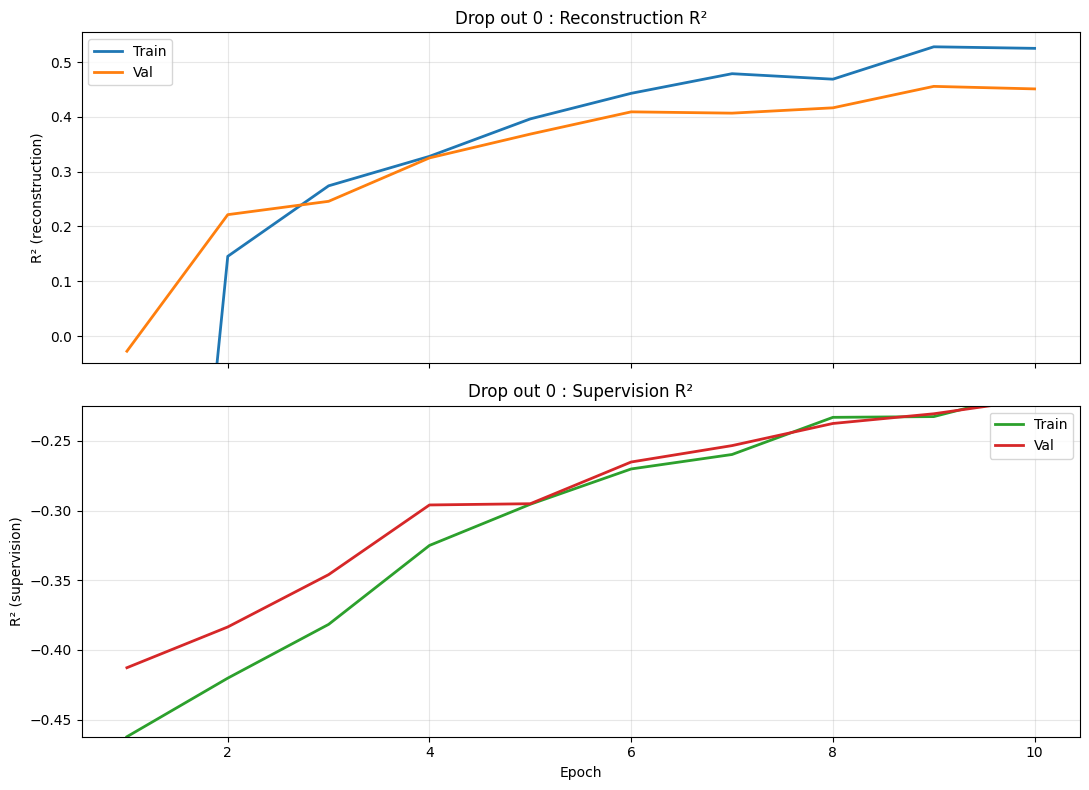

 33%|███▎      | 1/3 [01:16<02:32, 76.31s/it]

Training model with dropout 0.15


Epoch 01 | loss=1809.734 | R2_rec_train=-3.2008 | R2_rec_val=-0.0195 | R2_sup_train=-0.4697 | R2_sup_val=-0.2555


Epoch 02 | loss=673.035 | R2_rec_train=-0.4951 | R2_rec_val=-0.0205 | R2_sup_train=-0.4468 | R2_sup_val=-0.2554


Epoch 03 | loss=628.324 | R2_rec_train=-0.4185 | R2_rec_val=0.0809 | R2_sup_train=-0.4482 | R2_sup_val=-0.2544


Epoch 04 | loss=586.433 | R2_rec_train=-0.3268 | R2_rec_val=0.1840 | R2_sup_train=-0.4484 | R2_sup_val=-0.2453


Epoch 05 | loss=512.835 | R2_rec_train=-0.1917 | R2_rec_val=0.2554 | R2_sup_train=-0.4315 | R2_sup_val=-0.2378


Epoch 06 | loss=468.129 | R2_rec_train=-0.1139 | R2_rec_val=0.2791 | R2_sup_train=-0.4344 | R2_sup_val=-0.2383


Epoch 07 | loss=415.733 | R2_rec_train=-0.0009 | R2_rec_val=0.3597 | R2_sup_train=-0.4323 | R2_sup_val=-0.2373


Epoch 08 | loss=384.244 | R2_rec_train=0.0626 | R2_rec_val=0.3788 | R2_sup_train=-0.4291 | R2_sup_val=-0.2330


Epoch 09 | loss=367.124 | R2_rec_train=0.0906 | R2_rec_val=0.3843 | R2_sup_train=-0.4263 | R2_sup_val=-0.2340


100%|██████████| 10/10 [01:12<00:00,  7.22s/it]

Epoch 10 | loss=352.733 | R2_rec_train=0.1146 | R2_rec_val=0.3979 | R2_sup_train=-0.4220 | R2_sup_val=-0.2335


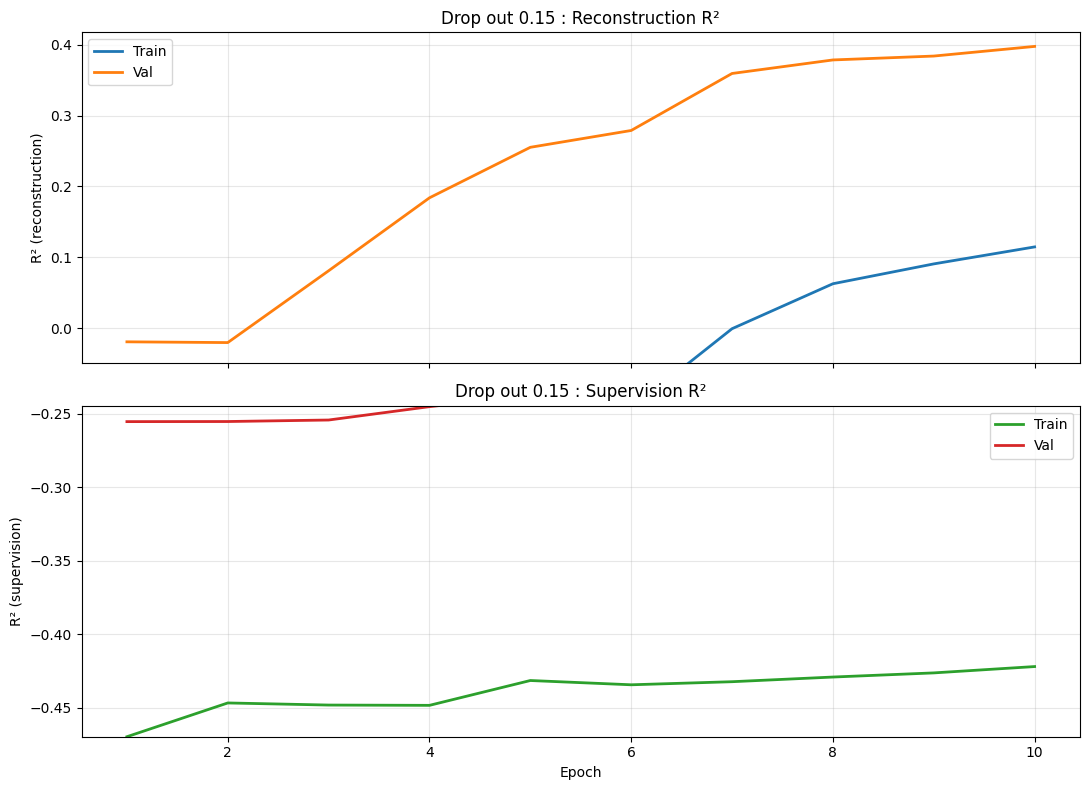

 67%|██████▋   | 2/3 [02:28<01:14, 74.08s/it]

Training model with dropout 0.3


Epoch 01 | loss=2369.376 | R2_rec_train=-3.9635 | R2_rec_val=-0.0207 | R2_sup_train=-0.6756 | R2_sup_val=-0.2753


Epoch 02 | loss=1002.961 | R2_rec_train=-1.0132 | R2_rec_val=-0.0250 | R2_sup_train=-0.3092 | R2_sup_val=-0.2529


Epoch 03 | loss=961.091 | R2_rec_train=-0.9518 | R2_rec_val=-0.0308 | R2_sup_train=-0.2859 | R2_sup_val=-0.2453


Epoch 04 | loss=921.758 | R2_rec_train=-0.8949 | R2_rec_val=-0.0319 | R2_sup_train=-0.2713 | R2_sup_val=-0.2412


Epoch 05 | loss=877.969 | R2_rec_train=-0.8298 | R2_rec_val=-0.0345 | R2_sup_train=-0.2691 | R2_sup_val=-0.2462


Epoch 06 | loss=830.704 | R2_rec_train=-0.7589 | R2_rec_val=-0.0454 | R2_sup_train=-0.2664 | R2_sup_val=-0.2459


Epoch 07 | loss=780.051 | R2_rec_train=-0.6814 | R2_rec_val=-0.0500 | R2_sup_train=-0.2531 | R2_sup_val=-0.2297


Epoch 08 | loss=675.735 | R2_rec_train=-0.4940 | R2_rec_val=0.0696 | R2_sup_train=-0.3443 | R2_sup_val=-0.3241


Epoch 09 | loss=591.395 | R2_rec_train=-0.3473 | R2_rec_val=0.0710 | R2_sup_train=-0.6451 | R2_sup_val=-0.4150


100%|██████████| 10/10 [01:13<00:00,  7.37s/it]

Epoch 10 | loss=539.742 | R2_rec_train=-0.2625 | R2_rec_val=0.0836 | R2_sup_train=-0.6789 | R2_sup_val=-0.4657


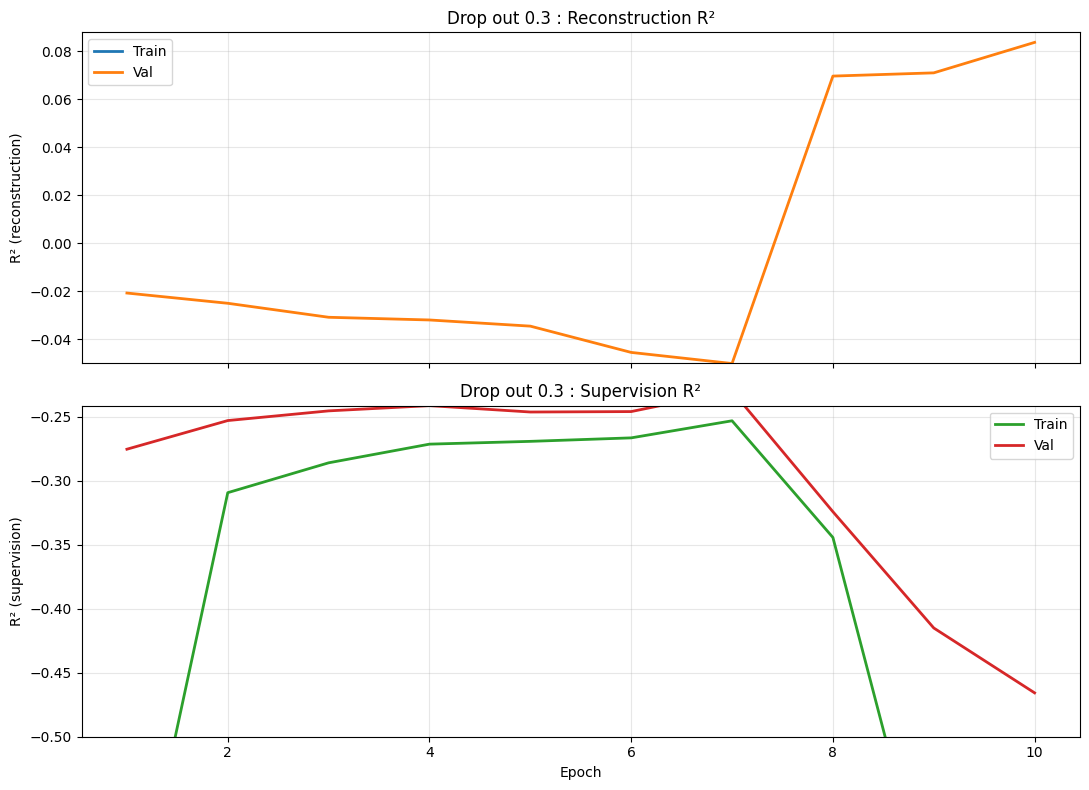

100%|██████████| 3/3 [03:42<00:00, 74.29s/it]


In [14]:
results_drop_out = {}
for p, model in tqdm(models_drop_out.items()):
    print(f"Training model with dropout {p}")
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CombinedLoss(alpha=alpha, beta=beta)
    results_drop_out[p] = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
    title = f"Drop out {p}"
    )

## Batch normalization

In [15]:
bn_values = {"True":True, "False":False}
models_bn = { k : AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
    use_bn=v 
) for k, v in  bn_values.items()}

  0%|          | 0/2 [00:00<?, ?it/s]

Training model with dropout True


Epoch 01 | loss=3562.573 | R2_rec_train=-4.9778 | R2_rec_val=0.3175 | R2_sup_train=-0.5028 | R2_sup_val=-0.4312


Epoch 02 | loss=136.525 | R2_rec_train=0.5301 | R2_rec_val=0.4989 | R2_sup_train=-0.4884 | R2_sup_val=-0.4100


Epoch 03 | loss=114.384 | R2_rec_train=0.5898 | R2_rec_val=0.5448 | R2_sup_train=-0.5004 | R2_sup_val=-0.4233


Epoch 04 | loss=100.392 | R2_rec_train=0.6277 | R2_rec_val=0.5790 | R2_sup_train=-0.5025 | R2_sup_val=-0.3370


Epoch 05 | loss=88.818 | R2_rec_train=0.6587 | R2_rec_val=0.5919 | R2_sup_train=-0.4889 | R2_sup_val=-0.4164


Epoch 06 | loss=82.238 | R2_rec_train=0.6749 | R2_rec_val=0.6144 | R2_sup_train=-0.5067 | R2_sup_val=-0.3702


Epoch 07 | loss=75.576 | R2_rec_train=0.6911 | R2_rec_val=0.6206 | R2_sup_train=-0.5383 | R2_sup_val=-0.4709


Epoch 08 | loss=71.717 | R2_rec_train=0.7012 | R2_rec_val=0.6146 | R2_sup_train=-0.5442 | R2_sup_val=-0.4193


Epoch 09 | loss=69.220 | R2_rec_train=0.7078 | R2_rec_val=0.6289 | R2_sup_train=-0.5484 | R2_sup_val=-0.3992


100%|██████████| 10/10 [01:20<00:00,  8.02s/it]

Epoch 10 | loss=67.196 | R2_rec_train=0.7142 | R2_rec_val=0.6288 | R2_sup_train=-0.5536 | R2_sup_val=-0.4539


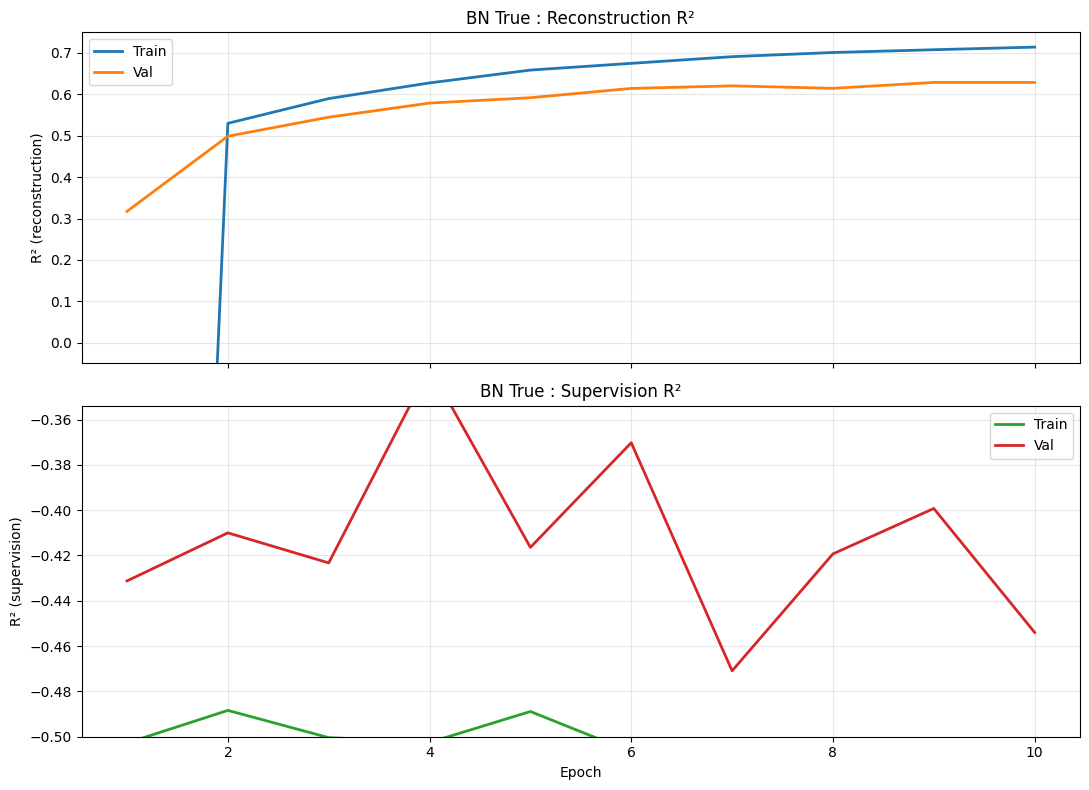

 50%|█████     | 1/2 [01:20<01:20, 80.62s/it]

Training model with dropout False


Epoch 01 | loss=1111.368 | R2_rec_train=-1.7140 | R2_rec_val=0.1147 | R2_sup_train=-0.3215 | R2_sup_val=-0.2773


Epoch 02 | loss=298.882 | R2_rec_train=0.1178 | R2_rec_val=0.0438 | R2_sup_train=-0.2542 | R2_sup_val=-0.1769


Epoch 03 | loss=267.259 | R2_rec_train=0.1690 | R2_rec_val=0.2246 | R2_sup_train=-0.4203 | R2_sup_val=-0.2773


Epoch 04 | loss=203.987 | R2_rec_train=0.3277 | R2_rec_val=0.2927 | R2_sup_train=-0.6467 | R2_sup_val=-0.4829


Epoch 05 | loss=183.007 | R2_rec_train=0.3845 | R2_rec_val=0.3360 | R2_sup_train=-0.8753 | R2_sup_val=-0.4631


Epoch 06 | loss=168.053 | R2_rec_train=0.4281 | R2_rec_val=0.3705 | R2_sup_train=-0.8509 | R2_sup_val=-0.4188


Epoch 07 | loss=158.479 | R2_rec_train=0.4681 | R2_rec_val=0.3949 | R2_sup_train=-0.9779 | R2_sup_val=-0.6136


Epoch 08 | loss=157.519 | R2_rec_train=0.4787 | R2_rec_val=0.4237 | R2_sup_train=-1.0946 | R2_sup_val=-0.7480


Epoch 09 | loss=147.328 | R2_rec_train=0.5001 | R2_rec_val=0.4617 | R2_sup_train=-1.1264 | R2_sup_val=-0.8409


100%|██████████| 10/10 [01:09<00:00,  6.98s/it]

Epoch 10 | loss=163.421 | R2_rec_train=0.4857 | R2_rec_val=0.5049 | R2_sup_train=-1.3645 | R2_sup_val=-0.9723


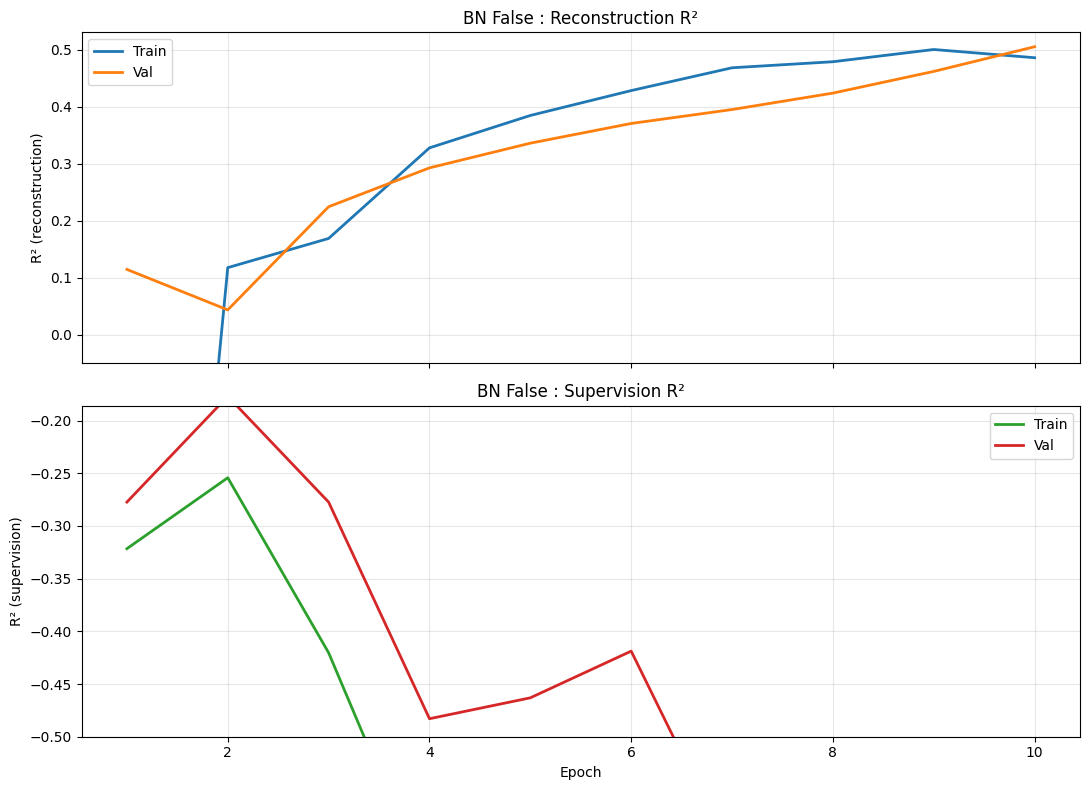

100%|██████████| 2/2 [02:30<00:00, 75.38s/it]


In [16]:
results_bn = {}
for p, model in tqdm(models_bn.items()):
    print(f"Training model with dropout {p}")
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CombinedLoss(alpha=alpha, beta=beta)
    results_bn[p] = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
    title=f"BN {p}"
    )

## Activation

In [12]:
activation_values = {"ReLU":torch.nn.ReLU, "SiLU":torch.nn.SiLU, "LeakyReLU":torch.nn.LeakyReLU}
models_activation = { k : AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
    activation=v 
) for k, v in  activation_values.items()}

  0%|          | 0/3 [00:00<?, ?it/s]

Training model with activation ReLU


Epoch 01 | loss=1067.792 | R2_rec_train=-1.6465 | R2_rec_val=0.0753 | R2_sup_train=-0.3764 | R2_sup_val=-0.2299


Epoch 02 | loss=258.068 | R2_rec_train=0.2038 | R2_rec_val=0.1521 | R2_sup_train=-0.3978 | R2_sup_val=-0.3456


Epoch 03 | loss=230.184 | R2_rec_train=0.2655 | R2_rec_val=0.2417 | R2_sup_train=-0.3729 | R2_sup_val=-0.1762


Epoch 04 | loss=208.540 | R2_rec_train=0.3223 | R2_rec_val=0.2977 | R2_sup_train=-0.3168 | R2_sup_val=-0.1667


Epoch 05 | loss=184.043 | R2_rec_train=0.3940 | R2_rec_val=0.3522 | R2_sup_train=-0.3095 | R2_sup_val=-0.1630


Epoch 06 | loss=160.513 | R2_rec_train=0.4680 | R2_rec_val=0.4134 | R2_sup_train=-0.3054 | R2_sup_val=-0.1575


Epoch 07 | loss=153.486 | R2_rec_train=0.4866 | R2_rec_val=0.4043 | R2_sup_train=-0.3024 | R2_sup_val=-0.1559


Epoch 08 | loss=145.056 | R2_rec_train=0.5115 | R2_rec_val=0.4482 | R2_sup_train=-0.3003 | R2_sup_val=-0.1551


Epoch 09 | loss=205.252 | R2_rec_train=0.3258 | R2_rec_val=0.4020 | R2_sup_train=-0.3001 | R2_sup_val=-0.1512


100%|██████████| 10/10 [01:18<00:00,  7.89s/it]

Epoch 10 | loss=151.590 | R2_rec_train=0.4821 | R2_rec_val=0.4192 | R2_sup_train=-0.3000 | R2_sup_val=-0.1535


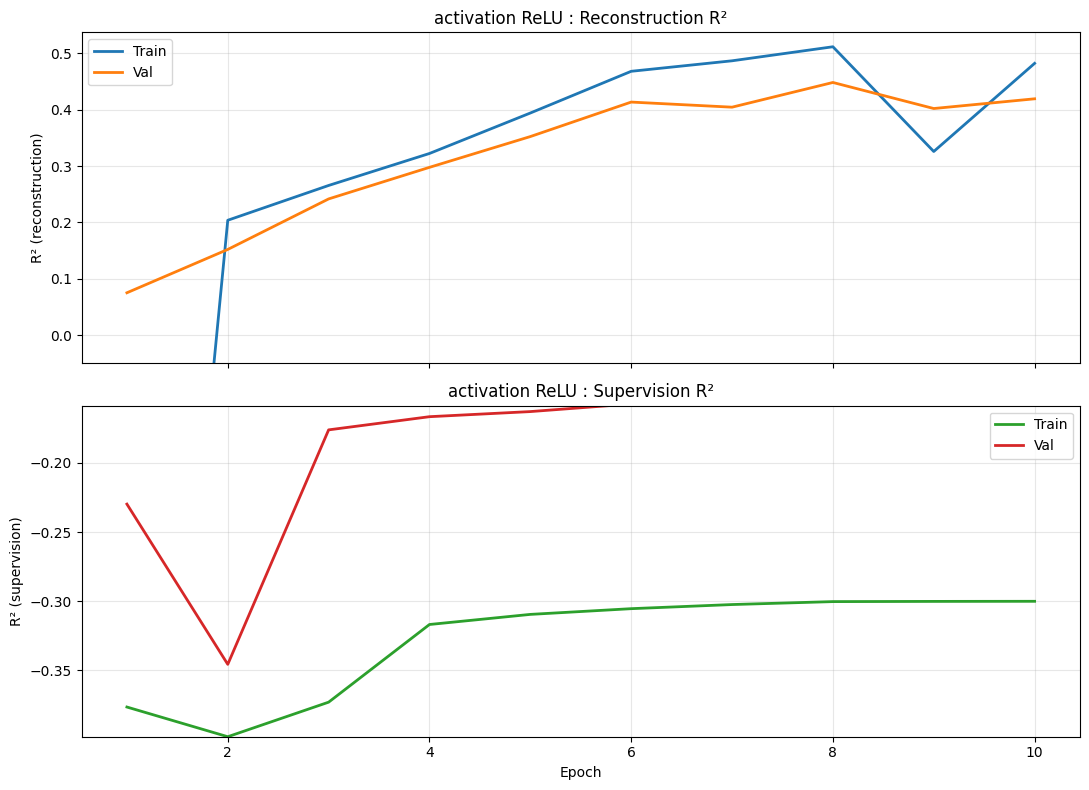

 33%|███▎      | 1/3 [01:20<02:41, 80.94s/it]

Training model with activation SiLU


Epoch 01 | loss=1096.017 | R2_rec_train=-1.4758 | R2_rec_val=0.0048 | R2_sup_train=-0.1663 | R2_sup_val=-0.1038


Epoch 02 | loss=306.055 | R2_rec_train=0.0804 | R2_rec_val=0.2394 | R2_sup_train=-0.0809 | R2_sup_val=-0.1068


Epoch 03 | loss=204.329 | R2_rec_train=0.3183 | R2_rec_val=0.2720 | R2_sup_train=-0.0239 | R2_sup_val=-0.0350


Epoch 04 | loss=192.721 | R2_rec_train=0.3642 | R2_rec_val=0.2964 | R2_sup_train=-0.0038 | R2_sup_val=-0.0042


Epoch 05 | loss=163.615 | R2_rec_train=0.4506 | R2_rec_val=0.3771 | R2_sup_train=-0.0246 | R2_sup_val=-0.0115


Epoch 06 | loss=146.146 | R2_rec_train=0.4966 | R2_rec_val=0.4041 | R2_sup_train=-0.0591 | R2_sup_val=-0.0262


Epoch 07 | loss=139.475 | R2_rec_train=0.5153 | R2_rec_val=0.4328 | R2_sup_train=-0.0964 | R2_sup_val=-0.0455


Epoch 08 | loss=185.513 | R2_rec_train=0.3922 | R2_rec_val=0.4232 | R2_sup_train=-0.1818 | R2_sup_val=-0.0970


Epoch 09 | loss=149.249 | R2_rec_train=0.4935 | R2_rec_val=0.3931 | R2_sup_train=-0.2156 | R2_sup_val=-0.0944


100%|██████████| 10/10 [01:04<00:00,  6.41s/it]

Epoch 10 | loss=146.653 | R2_rec_train=0.4936 | R2_rec_val=0.4269 | R2_sup_train=-0.2012 | R2_sup_val=-0.0969


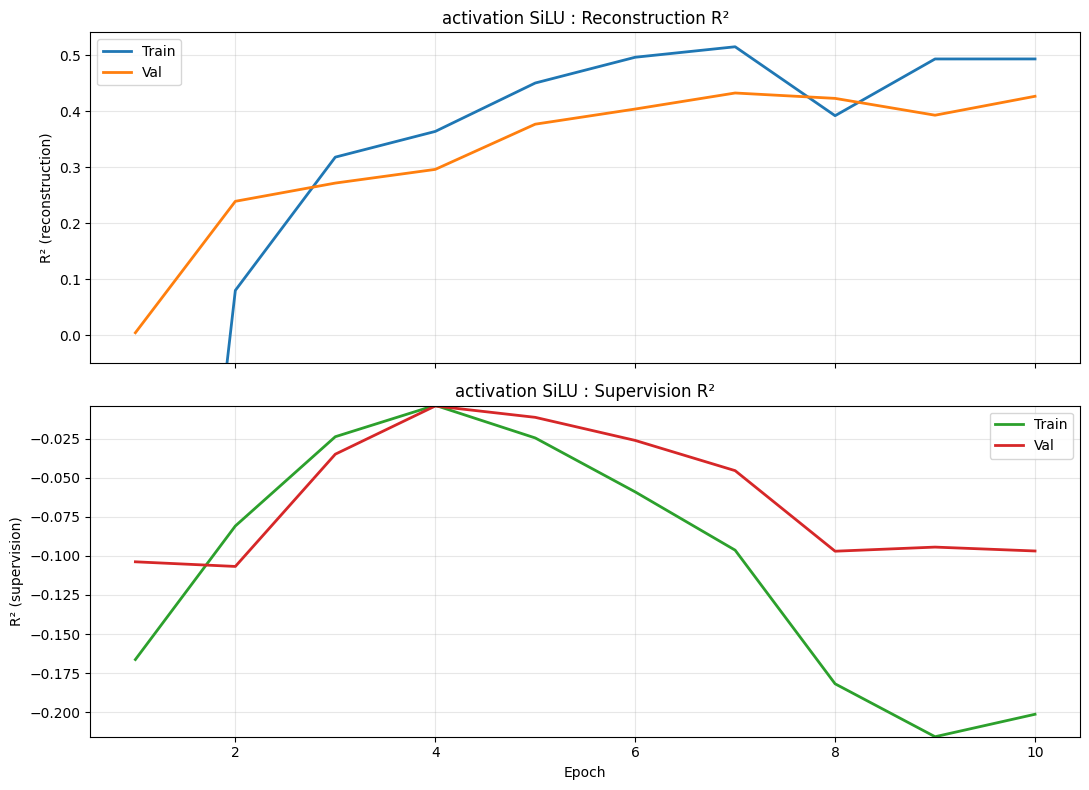

 67%|██████▋   | 2/3 [02:25<01:11, 71.28s/it]

Training model with activation LeakyReLU


Epoch 01 | loss=954.437 | R2_rec_train=-1.2619 | R2_rec_val=0.1786 | R2_sup_train=-0.0024 | R2_sup_val=-0.0265


Epoch 02 | loss=215.027 | R2_rec_train=0.3151 | R2_rec_val=0.3269 | R2_sup_train=-0.0168 | R2_sup_val=-0.0393


Epoch 03 | loss=167.634 | R2_rec_train=0.4420 | R2_rec_val=0.3801 | R2_sup_train=-0.0182 | R2_sup_val=-0.0441


Epoch 04 | loss=145.199 | R2_rec_train=0.4959 | R2_rec_val=0.4449 | R2_sup_train=-0.0155 | R2_sup_val=-0.0391


Epoch 05 | loss=133.931 | R2_rec_train=0.5312 | R2_rec_val=0.4971 | R2_sup_train=-0.0121 | R2_sup_val=-0.0295


Epoch 06 | loss=130.384 | R2_rec_train=0.5367 | R2_rec_val=0.5233 | R2_sup_train=-0.0119 | R2_sup_val=-0.0315


Epoch 07 | loss=114.147 | R2_rec_train=0.5861 | R2_rec_val=0.4972 | R2_sup_train=-0.0103 | R2_sup_val=-0.0273


Epoch 08 | loss=103.575 | R2_rec_train=0.6185 | R2_rec_val=0.5591 | R2_sup_train=-0.0091 | R2_sup_val=-0.0258


Epoch 09 | loss=107.004 | R2_rec_train=0.6041 | R2_rec_val=0.5512 | R2_sup_train=-0.0090 | R2_sup_val=-0.0282


100%|██████████| 10/10 [01:10<00:00,  7.02s/it]

Epoch 10 | loss=93.978 | R2_rec_train=0.6393 | R2_rec_val=0.4424 | R2_sup_train=-0.0089 | R2_sup_val=-0.0223


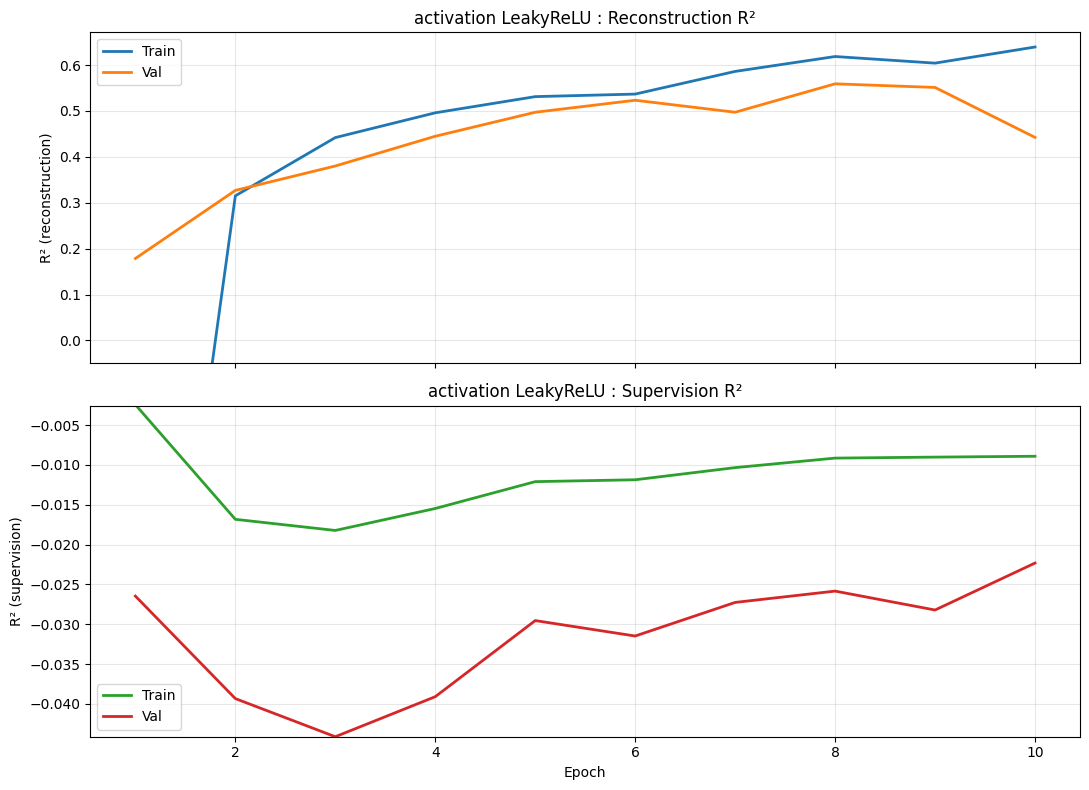

100%|██████████| 3/3 [03:36<00:00, 72.01s/it]


In [13]:
results_activation = {}
for p, model in tqdm(models_activation.items()):
    print(f"Training model with activation {p}")
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CombinedLoss(alpha=alpha, beta=beta)
    results_activation[p] = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
    title=f"activation {p}"
    )

# Supervision Tweaking

In [12]:
lr = 1e-2
device = torch.device("cuda")
alpha = 0.0
beta = 1.0
n_epochs = 10

In [13]:
n_feat = len(features)
n_latent = 16
encoder_hidden = [64, 32, 32]
decoder_hidden = [32, 64]
head_hidden = [8, 4]

### Drop out 

In [14]:
drop_out_values = [0, 0.15, 0.3]

In [15]:
models_drop_out = { p : AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
    dropout_p=p
) for p in drop_out_values }

  0%|          | 0/3 [00:00<?, ?it/s]

Training model with dropout 0


Epoch 01 | loss=254.556 | R2_rec_train=-81.7477 | R2_rec_val=-0.8624 | R2_sup_train=0.0068 | R2_sup_val=0.0043


Epoch 02 | loss=254.363 | R2_rec_train=-82.1280 | R2_rec_val=-1.2161 | R2_sup_train=0.0076 | R2_sup_val=-0.0007


Epoch 03 | loss=254.206 | R2_rec_train=-82.6901 | R2_rec_val=-1.7642 | R2_sup_train=0.0082 | R2_sup_val=0.0004


Epoch 04 | loss=253.975 | R2_rec_train=-84.3150 | R2_rec_val=-3.8265 | R2_sup_train=0.0091 | R2_sup_val=0.0001


Epoch 05 | loss=254.371 | R2_rec_train=-82.0013 | R2_rec_val=-1.3691 | R2_sup_train=0.0076 | R2_sup_val=0.0002


Epoch 06 | loss=254.415 | R2_rec_train=-81.8563 | R2_rec_val=-1.0304 | R2_sup_train=0.0074 | R2_sup_val=0.0005


Epoch 07 | loss=254.497 | R2_rec_train=-82.0333 | R2_rec_val=-0.6207 | R2_sup_train=0.0070 | R2_sup_val=0.0013


Epoch 08 | loss=254.556 | R2_rec_train=-81.7494 | R2_rec_val=-0.6979 | R2_sup_train=0.0068 | R2_sup_val=-0.0002


Epoch 09 | loss=254.254 | R2_rec_train=-81.7730 | R2_rec_val=-0.6836 | R2_sup_train=0.0080 | R2_sup_val=0.0013


100%|██████████| 10/10 [01:35<00:00,  9.57s/it]

Epoch 10 | loss=254.033 | R2_rec_train=-81.7671 | R2_rec_val=-0.7673 | R2_sup_train=0.0089 | R2_sup_val=0.0023


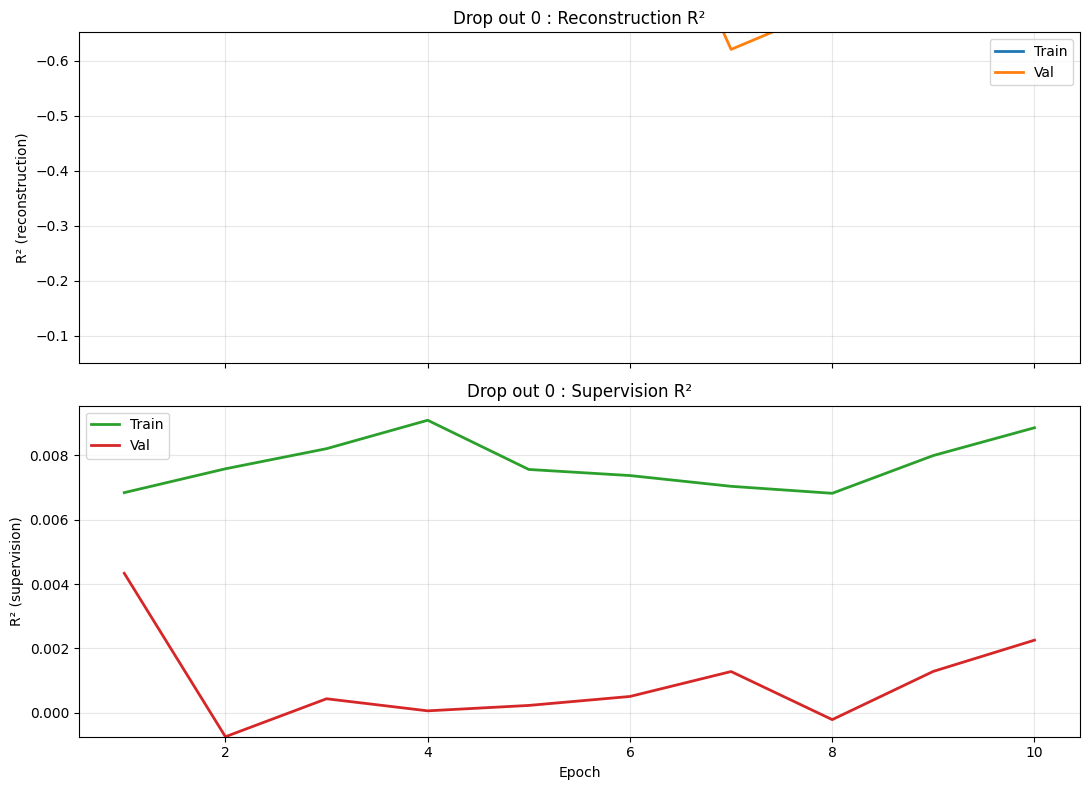

 33%|███▎      | 1/3 [01:39<03:18, 99.45s/it]

Training model with dropout 0.15


Epoch 01 | loss=256.505 | R2_rec_train=-82.0109 | R2_rec_val=-0.7143 | R2_sup_train=-0.0008 | R2_sup_val=-0.0016


Epoch 02 | loss=256.382 | R2_rec_train=-82.1167 | R2_rec_val=-0.7175 | R2_sup_train=-0.0003 | R2_sup_val=-0.0011


Epoch 03 | loss=256.392 | R2_rec_train=-82.1265 | R2_rec_val=-0.7235 | R2_sup_train=-0.0003 | R2_sup_val=-0.0010


Epoch 04 | loss=256.396 | R2_rec_train=-82.0772 | R2_rec_val=-0.7457 | R2_sup_train=-0.0004 | R2_sup_val=-0.0009


Epoch 05 | loss=256.399 | R2_rec_train=-82.0146 | R2_rec_val=-0.9026 | R2_sup_train=-0.0004 | R2_sup_val=-0.0009


Epoch 06 | loss=256.400 | R2_rec_train=-82.4360 | R2_rec_val=-1.0880 | R2_sup_train=-0.0004 | R2_sup_val=-0.0008


Epoch 07 | loss=256.401 | R2_rec_train=-82.7286 | R2_rec_val=-1.0881 | R2_sup_train=-0.0004 | R2_sup_val=-0.0008


Epoch 08 | loss=256.402 | R2_rec_train=-82.7297 | R2_rec_val=-1.0992 | R2_sup_train=-0.0004 | R2_sup_val=-0.0008


Epoch 09 | loss=256.402 | R2_rec_train=-82.7772 | R2_rec_val=-1.1258 | R2_sup_train=-0.0004 | R2_sup_val=-0.0008


100%|██████████| 10/10 [01:23<00:00,  8.37s/it]

Epoch 10 | loss=256.402 | R2_rec_train=-82.8277 | R2_rec_val=-1.1312 | R2_sup_train=-0.0004 | R2_sup_val=-0.0008


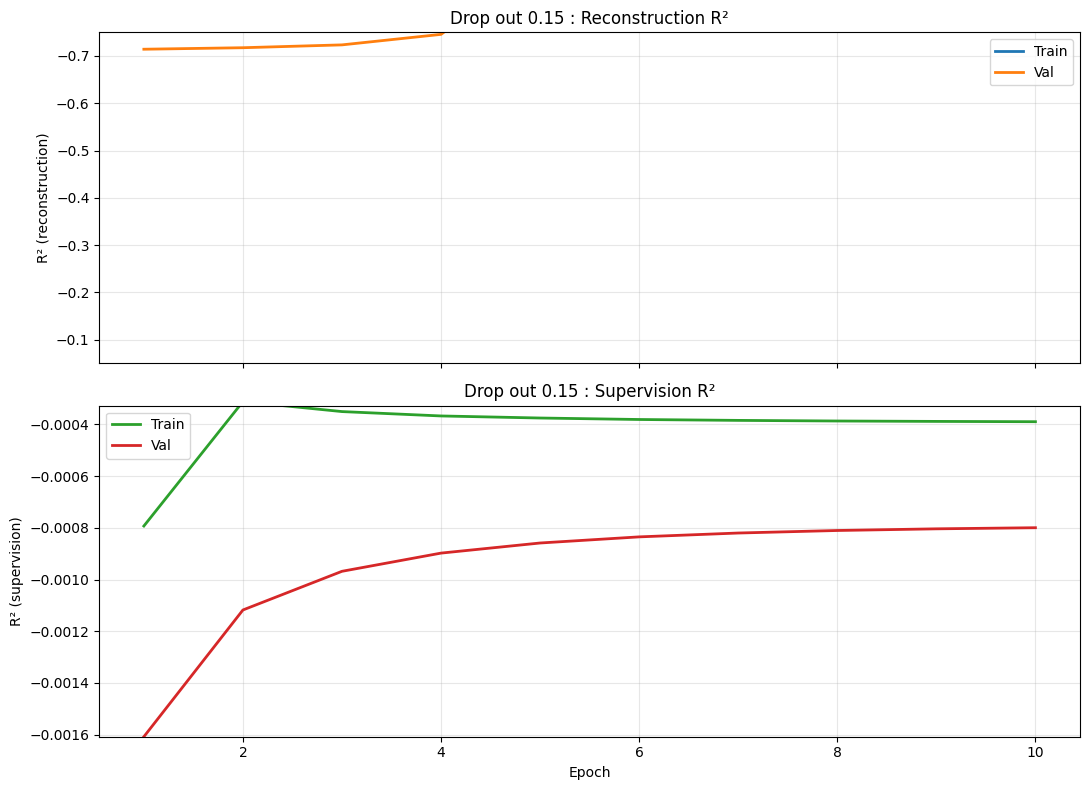

 67%|██████▋   | 2/3 [03:03<01:30, 90.38s/it]

Training model with dropout 0.3


Epoch 01 | loss=256.354 | R2_rec_train=-81.8603 | R2_rec_val=-0.7805 | R2_sup_train=-0.0002 | R2_sup_val=-0.0011


Epoch 02 | loss=256.399 | R2_rec_train=-81.8890 | R2_rec_val=-0.8053 | R2_sup_train=-0.0004 | R2_sup_val=-0.0009


Epoch 03 | loss=256.401 | R2_rec_train=-81.9129 | R2_rec_val=-0.8253 | R2_sup_train=-0.0004 | R2_sup_val=-0.0009


Epoch 04 | loss=256.402 | R2_rec_train=-81.9267 | R2_rec_val=-0.8223 | R2_sup_train=-0.0004 | R2_sup_val=-0.0008


Epoch 05 | loss=256.402 | R2_rec_train=-81.9250 | R2_rec_val=-0.8223 | R2_sup_train=-0.0004 | R2_sup_val=-0.0008


Epoch 06 | loss=256.402 | R2_rec_train=-81.9195 | R2_rec_val=-0.8183 | R2_sup_train=-0.0004 | R2_sup_val=-0.0008


Epoch 07 | loss=256.402 | R2_rec_train=-81.9144 | R2_rec_val=-0.8137 | R2_sup_train=-0.0004 | R2_sup_val=-0.0008


Epoch 08 | loss=256.403 | R2_rec_train=-81.9260 | R2_rec_val=-0.8270 | R2_sup_train=-0.0004 | R2_sup_val=-0.0008


Epoch 09 | loss=256.403 | R2_rec_train=-81.9273 | R2_rec_val=-0.8246 | R2_sup_train=-0.0004 | R2_sup_val=-0.0008


100%|██████████| 10/10 [01:33<00:00,  9.32s/it]

Epoch 10 | loss=256.403 | R2_rec_train=-81.9306 | R2_rec_val=-0.8279 | R2_sup_train=-0.0004 | R2_sup_val=-0.0008


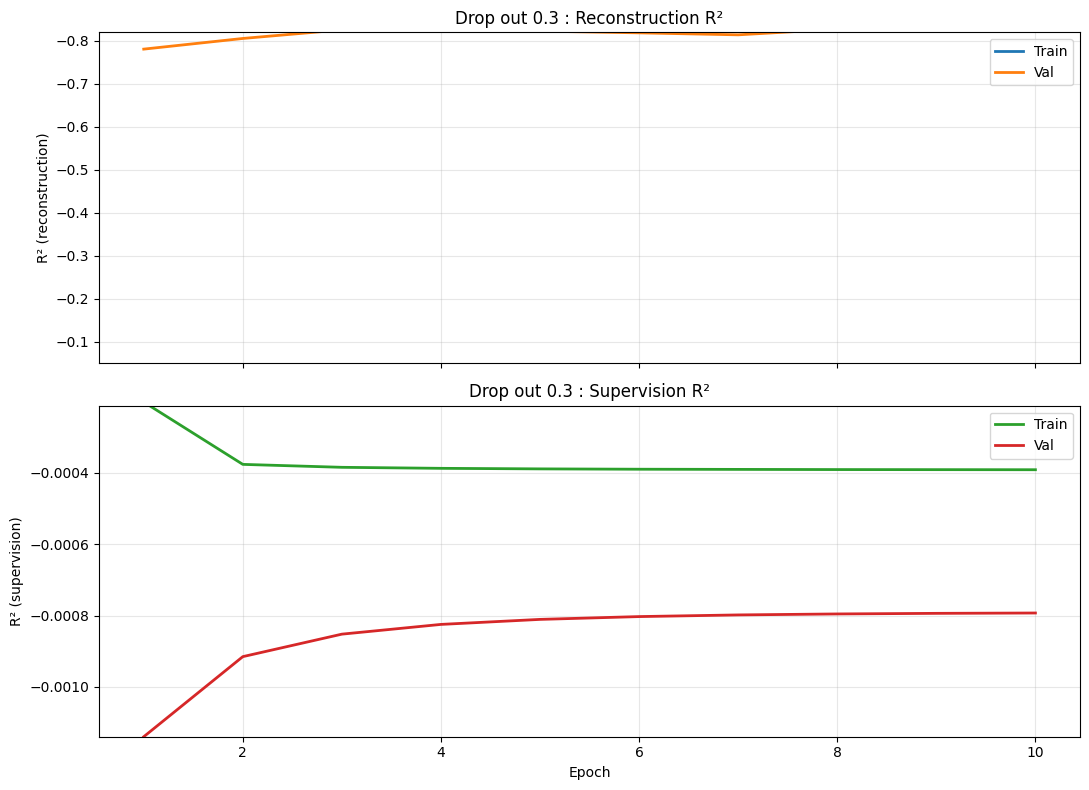

100%|██████████| 3/3 [04:37<00:00, 92.35s/it]


In [16]:
results_drop_out = {}
for p, model in tqdm(models_drop_out.items()):
    print(f"Training model with dropout {p}")
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CombinedLoss(alpha=alpha, beta=beta)
    results_drop_out[p] = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
    title = f"Drop out {p}"
    )

## Batch normalization

In [17]:
bn_values = {"True":True, "False":False}
models_bn = { k : AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
    use_bn=v 
) for k, v in  bn_values.items()}

  0%|          | 0/2 [00:00<?, ?it/s]

Training model with dropout True


Epoch 01 | loss=254.844 | R2_rec_train=-81.4510 | R2_rec_val=-2.3066 | R2_sup_train=0.0057 | R2_sup_val=0.0001


Epoch 02 | loss=254.254 | R2_rec_train=-81.3344 | R2_rec_val=-2.2762 | R2_sup_train=0.0080 | R2_sup_val=0.0025


Epoch 03 | loss=253.508 | R2_rec_train=-81.3769 | R2_rec_val=-2.4340 | R2_sup_train=0.0109 | R2_sup_val=0.0020


Epoch 04 | loss=252.557 | R2_rec_train=-81.3777 | R2_rec_val=-2.5768 | R2_sup_train=0.0146 | R2_sup_val=0.0064


Epoch 05 | loss=251.959 | R2_rec_train=-81.3916 | R2_rec_val=-2.9467 | R2_sup_train=0.0169 | R2_sup_val=0.0040


Epoch 06 | loss=251.935 | R2_rec_train=-81.3959 | R2_rec_val=-2.1190 | R2_sup_train=0.0170 | R2_sup_val=0.0053


Epoch 07 | loss=251.696 | R2_rec_train=-81.3627 | R2_rec_val=-2.8463 | R2_sup_train=0.0180 | R2_sup_val=0.0024


Epoch 08 | loss=251.478 | R2_rec_train=-81.3175 | R2_rec_val=-2.5350 | R2_sup_train=0.0188 | R2_sup_val=0.0041


Epoch 09 | loss=251.257 | R2_rec_train=-81.3629 | R2_rec_val=-2.2379 | R2_sup_train=0.0196 | R2_sup_val=0.0067


100%|██████████| 10/10 [01:39<00:00,  9.92s/it]

Epoch 10 | loss=250.983 | R2_rec_train=-81.3633 | R2_rec_val=-2.0084 | R2_sup_train=0.0207 | R2_sup_val=0.0061


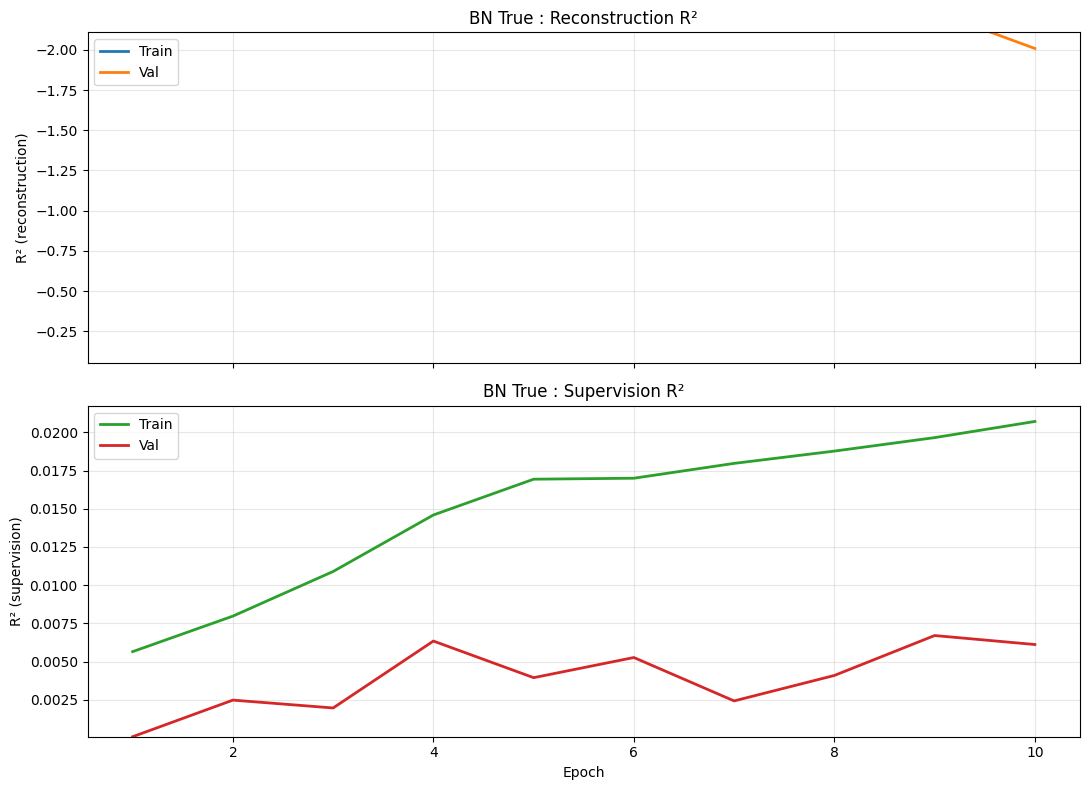

 50%|█████     | 1/2 [01:39<01:39, 99.53s/it]

Training model with dropout False


Epoch 01 | loss=255.050 | R2_rec_train=-82.0800 | R2_rec_val=-1.1894 | R2_sup_train=0.0049 | R2_sup_val=0.0059


Epoch 02 | loss=254.302 | R2_rec_train=-85.0711 | R2_rec_val=-2.8707 | R2_sup_train=0.0078 | R2_sup_val=0.0053


Epoch 03 | loss=254.250 | R2_rec_train=-83.0539 | R2_rec_val=-1.1533 | R2_sup_train=0.0080 | R2_sup_val=0.0019


Epoch 04 | loss=254.712 | R2_rec_train=-82.0393 | R2_rec_val=-1.1140 | R2_sup_train=0.0062 | R2_sup_val=-0.0049


Epoch 05 | loss=256.244 | R2_rec_train=-102.3331 | R2_rec_val=-25.4509 | R2_sup_train=0.0002 | R2_sup_val=-0.0034


Epoch 06 | loss=256.258 | R2_rec_train=-103.7374 | R2_rec_val=-25.0522 | R2_sup_train=0.0002 | R2_sup_val=-0.0033


Epoch 07 | loss=256.258 | R2_rec_train=-103.4518 | R2_rec_val=-24.5683 | R2_sup_train=0.0002 | R2_sup_val=-0.0034


Epoch 08 | loss=256.260 | R2_rec_train=-103.5161 | R2_rec_val=-23.2523 | R2_sup_train=0.0002 | R2_sup_val=-0.0036


Epoch 09 | loss=256.264 | R2_rec_train=-101.5082 | R2_rec_val=-22.3797 | R2_sup_train=0.0001 | R2_sup_val=-0.0038


100%|██████████| 10/10 [01:24<00:00,  8.44s/it]

Epoch 10 | loss=256.275 | R2_rec_train=-101.0699 | R2_rec_val=-21.6259 | R2_sup_train=0.0001 | R2_sup_val=-0.0036


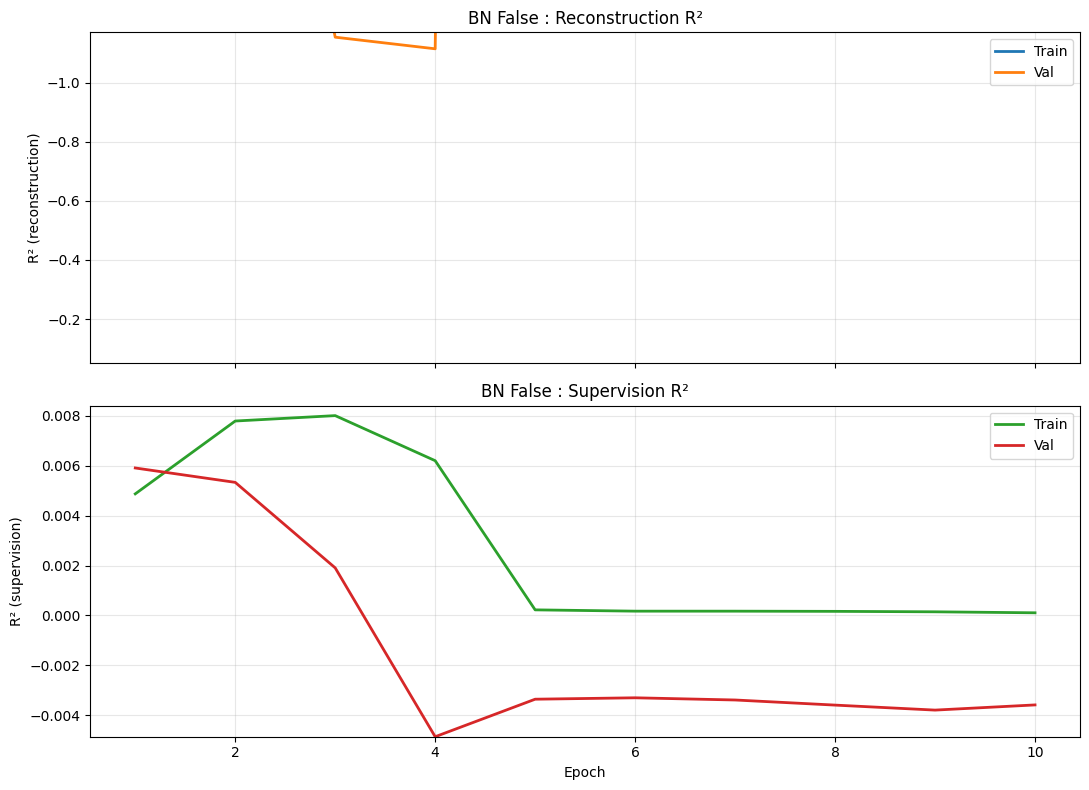

100%|██████████| 2/2 [03:04<00:00, 92.16s/it]


In [18]:
results_bn = {}
for p, model in tqdm(models_bn.items()):
    print(f"Training model with dropout {p}")
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CombinedLoss(alpha=alpha, beta=beta)
    results_bn[p] = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
    title=f"BN {p}"
    )

## Activation

In [19]:
activation_values = {"ReLU":torch.nn.ReLU, "SiLU":torch.nn.SiLU, "LeakyReLU":torch.nn.LeakyReLU}
models_activation = { k : AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
    activation=v 
) for k, v in  activation_values.items()}

  0%|          | 0/3 [00:00<?, ?it/s]

Training model with activation ReLU


Epoch 01 | loss=254.972 | R2_rec_train=-81.6503 | R2_rec_val=-0.5421 | R2_sup_train=0.0052 | R2_sup_val=0.0038


Epoch 02 | loss=254.452 | R2_rec_train=-81.5610 | R2_rec_val=-0.5743 | R2_sup_train=0.0072 | R2_sup_val=0.0055


Epoch 03 | loss=254.903 | R2_rec_train=-80.7145 | R2_rec_val=-0.6362 | R2_sup_train=0.0055 | R2_sup_val=0.0008


Epoch 04 | loss=256.374 | R2_rec_train=-81.5220 | R2_rec_val=-0.5856 | R2_sup_train=-0.0003 | R2_sup_val=-0.0006


Epoch 05 | loss=256.412 | R2_rec_train=-81.5270 | R2_rec_val=-0.5856 | R2_sup_train=-0.0004 | R2_sup_val=-0.0007


Epoch 06 | loss=256.409 | R2_rec_train=-81.5270 | R2_rec_val=-0.5856 | R2_sup_train=-0.0004 | R2_sup_val=-0.0007


Epoch 07 | loss=256.407 | R2_rec_train=-81.5270 | R2_rec_val=-0.5856 | R2_sup_train=-0.0004 | R2_sup_val=-0.0007


Epoch 08 | loss=256.406 | R2_rec_train=-81.5270 | R2_rec_val=-0.5856 | R2_sup_train=-0.0004 | R2_sup_val=-0.0007


Epoch 09 | loss=256.405 | R2_rec_train=-81.5270 | R2_rec_val=-0.5856 | R2_sup_train=-0.0004 | R2_sup_val=-0.0008


100%|██████████| 10/10 [01:22<00:00,  8.27s/it]

Epoch 10 | loss=256.404 | R2_rec_train=-81.5270 | R2_rec_val=-0.5856 | R2_sup_train=-0.0004 | R2_sup_val=-0.0008


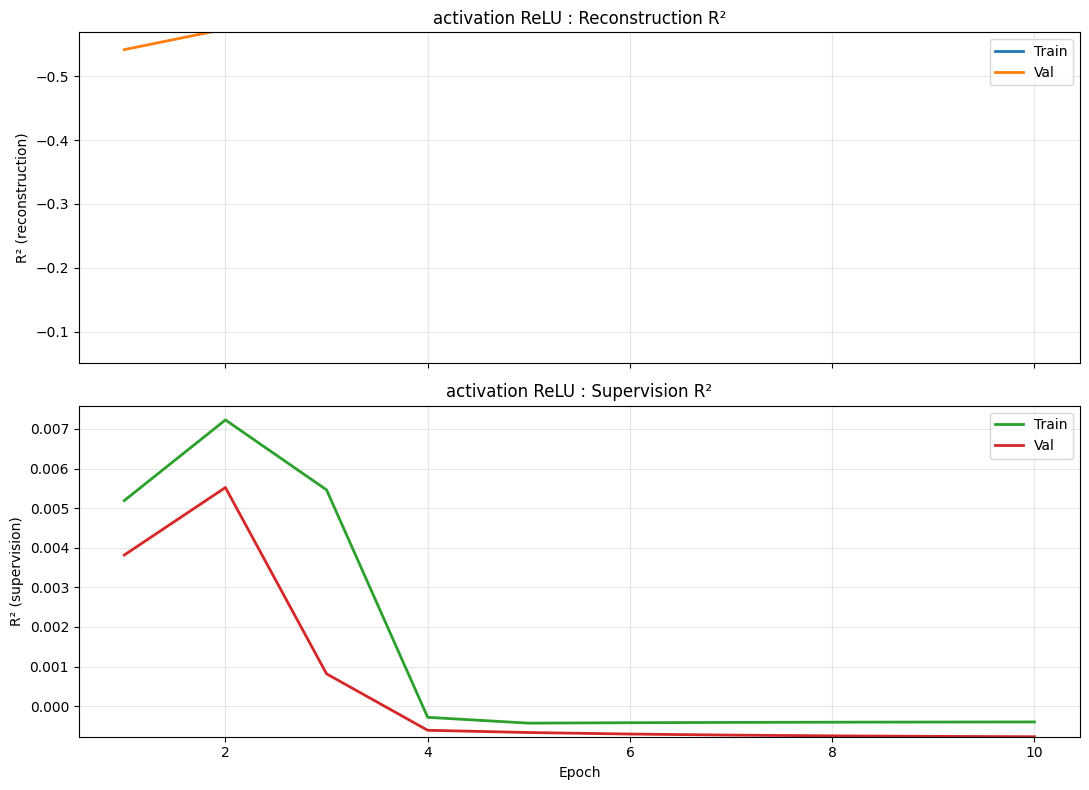

 33%|███▎      | 1/3 [01:23<02:46, 83.09s/it]

Training model with activation SiLU


Epoch 01 | loss=254.523 | R2_rec_train=-83.9006 | R2_rec_val=-0.7138 | R2_sup_train=0.0070 | R2_sup_val=0.0054


Epoch 02 | loss=254.409 | R2_rec_train=-80.6853 | R2_rec_val=-0.9866 | R2_sup_train=0.0074 | R2_sup_val=-0.0009


Epoch 03 | loss=254.142 | R2_rec_train=-80.7228 | R2_rec_val=-0.8860 | R2_sup_train=0.0085 | R2_sup_val=0.0022


Epoch 04 | loss=254.395 | R2_rec_train=-80.7865 | R2_rec_val=-2.2822 | R2_sup_train=0.0075 | R2_sup_val=0.0062


Epoch 05 | loss=254.384 | R2_rec_train=-80.6925 | R2_rec_val=-0.7405 | R2_sup_train=0.0075 | R2_sup_val=0.0013


Epoch 06 | loss=254.106 | R2_rec_train=-81.6862 | R2_rec_val=-0.5399 | R2_sup_train=0.0086 | R2_sup_val=0.0034


Epoch 07 | loss=254.343 | R2_rec_train=-80.6249 | R2_rec_val=-0.6898 | R2_sup_train=0.0076 | R2_sup_val=0.0022


Epoch 08 | loss=254.258 | R2_rec_train=-81.3718 | R2_rec_val=-0.6815 | R2_sup_train=0.0080 | R2_sup_val=0.0058


Epoch 09 | loss=254.415 | R2_rec_train=-81.9061 | R2_rec_val=-3.6994 | R2_sup_train=0.0074 | R2_sup_val=0.0062


100%|██████████| 10/10 [01:27<00:00,  8.79s/it]

Epoch 10 | loss=256.264 | R2_rec_train=-82.9135 | R2_rec_val=-0.7230 | R2_sup_train=0.0002 | R2_sup_val=-0.0037


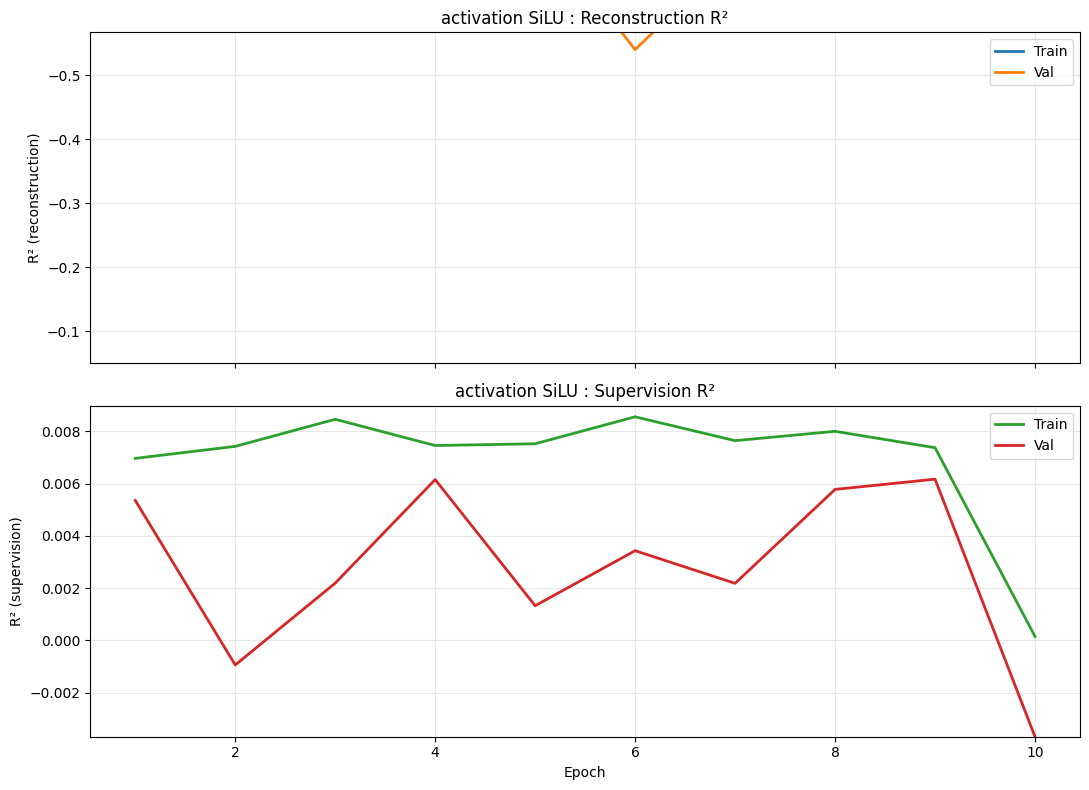

 67%|██████▋   | 2/3 [02:51<01:26, 86.11s/it]

Training model with activation LeakyReLU


Epoch 01 | loss=255.442 | R2_rec_train=-83.4595 | R2_rec_val=-1.8860 | R2_sup_train=0.0034 | R2_sup_val=-0.0012


Epoch 02 | loss=254.541 | R2_rec_train=-93.1972 | R2_rec_val=-16.8856 | R2_sup_train=0.0069 | R2_sup_val=0.0024


Epoch 03 | loss=254.199 | R2_rec_train=-225.8221 | R2_rec_val=-141.2296 | R2_sup_train=0.0082 | R2_sup_val=0.0027


Epoch 04 | loss=254.120 | R2_rec_train=-178.9281 | R2_rec_val=-139.2604 | R2_sup_train=0.0085 | R2_sup_val=0.0028


Epoch 05 | loss=253.763 | R2_rec_train=-196.3847 | R2_rec_val=-389.0833 | R2_sup_train=0.0099 | R2_sup_val=0.0001


Epoch 06 | loss=253.578 | R2_rec_train=-560.8792 | R2_rec_val=-2085.9373 | R2_sup_train=0.0106 | R2_sup_val=0.0073


Epoch 07 | loss=253.971 | R2_rec_train=-259.6737 | R2_rec_val=-64.8254 | R2_sup_train=0.0091 | R2_sup_val=-0.0011


Epoch 08 | loss=253.744 | R2_rec_train=-150.5693 | R2_rec_val=-103.2205 | R2_sup_train=0.0100 | R2_sup_val=0.0025


Epoch 09 | loss=253.919 | R2_rec_train=-1554.9851 | R2_rec_val=-2329.6914 | R2_sup_train=0.0093 | R2_sup_val=0.0065


100%|██████████| 10/10 [01:27<00:00,  8.70s/it]

Epoch 10 | loss=253.252 | R2_rec_train=-755.2345 | R2_rec_val=-1844.4823 | R2_sup_train=0.0119 | R2_sup_val=0.0071


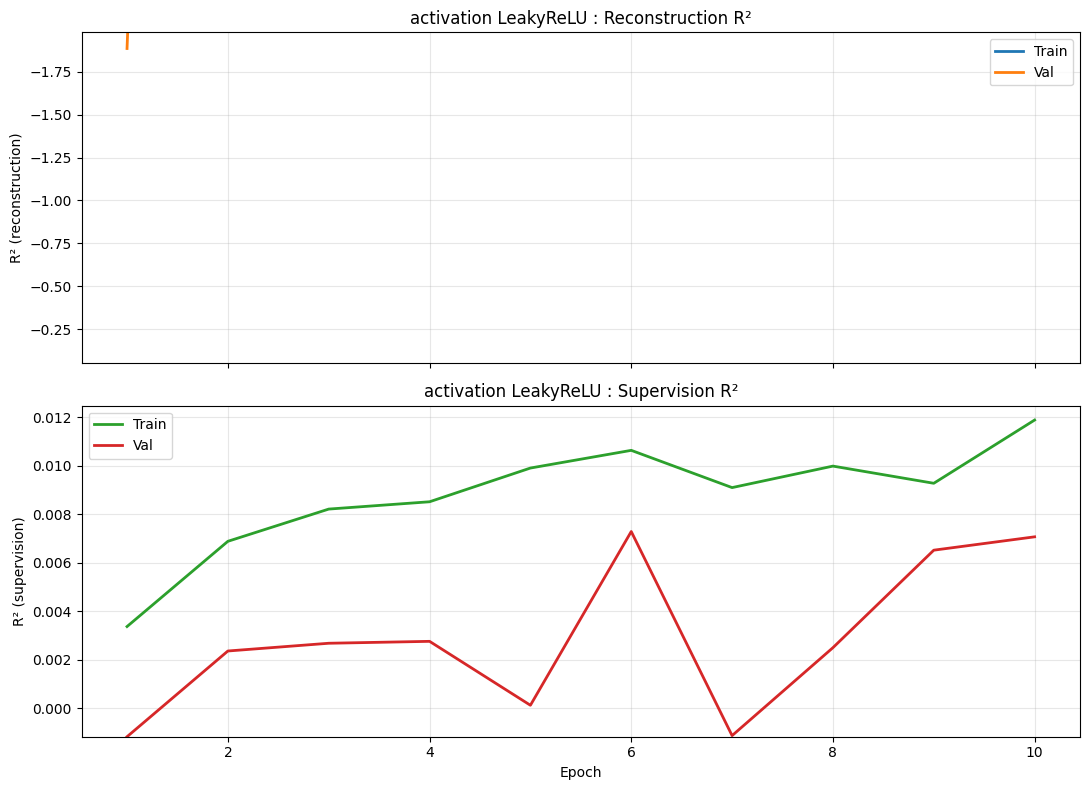

100%|██████████| 3/3 [04:18<00:00, 86.23s/it]


In [20]:
results_activation = {}
for p, model in tqdm(models_activation.items()):
    print(f"Training model with activation {p}")
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CombinedLoss(alpha=alpha, beta=beta)
    results_activation[p] = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
    title=f"activation {p}"
    )